# **Data Visualisation Notebook**

## Objectives

* Answer business requirement 1:
    * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.


## Inputs

* inputs/cherry_leaves-dataset/cherry-leaves/train
* inputs/cherry_leaves-dataset/cherry-leaves/test
* inputs/cherry_leaves-dataset/cherry-leaves/validation

## Outputs
* outputs/data-visualisation
* Image shape embeddings pickle file
* Plot showing mean and variability per label
* Plot demonstrating differences between healthy and infected leaves
* Image montage code to be used for answering Business Requirement 1, for Streamlit dashboard.

## Additional Comments

* The provided dataset as provided images that are all set to 250x250px


---

# Prepare notebook

## Import libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from matplotlib.image import imread

sns.set_style("white")

Get root dir for inputs access

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-ML/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print(f"You set a new current directory")

You set a new current directory


Confirm the new current directory as working directory

In [4]:
workdir = os.getcwd()
print(workdir)

/workspace/cherry-ML


### Import requirements now in root

In [5]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Set input directories:

In [6]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

my_data_dir

'inputs/cherry-leaves-dataset/cherry-leaves'

### Set output directory:

In [7]:
# set version in file path
version = 'v6'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(workdir) and version in os.listdir(workdir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


### Confirm train set label names and contents:

In [8]:
labels = os.listdir(train_path)
print(f'labels are:\n {labels}\n')

# confirm number of files in each train set label folder
for label in labels:
    label_path = f'{train_path}/{label}'
    print(f"Number of files in {label}: {len(os.listdir(label_path))}")


labels are:
 ['healthy', 'powdery_mildew']

Number of files in healthy: 1472
Number of files in powdery_mildew: 1472


# Section 1 - Data Visualiation

***


### Confirm all image sizes

Width range: 256 to 256
Height range: 256 to 256


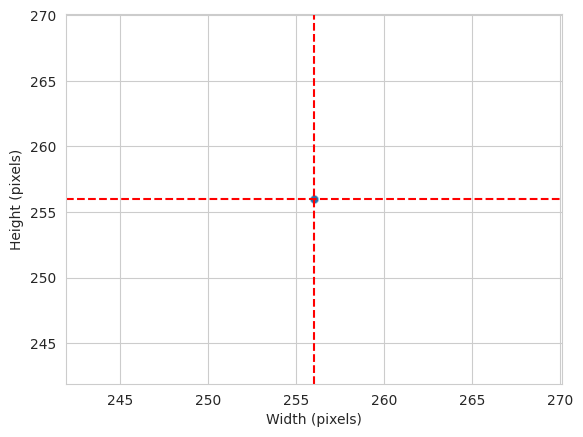

Width average: 256 
Height average: 256


In [9]:
dim1, dim2 = [], []

for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

print(f"Width range: {min(dim2)} to {max(dim2)}")
print(f"Height range: {min(dim1)} to {max(dim1)}")

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.savefig(f'{file_path}/dataset_size.png')
plt.show()

print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


#### OBSERVATION 
* We can clearly see that all the images are the same height and width: 256x256 pixels

As each image is the same shape, and a perfect square where both height and width of every image is 256 pixels, there is no need to alter image shape to get an average size for equal image handling.

For the sake of future scalability where images will not be the same size in other datasets, we will save the image shape as the mean average of each image in the dataset.

We will also consider scaling the images to 50x50 if required, to increase image handling performance.

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)  # 3 for standard RGB
image_shape

(256, 256, 3)

In [11]:
# Save the image embeddings:
joblib.dump(value=image_shape, filename=f'{file_path}/image_shape.pkl')

['outputs/v6/image_shape.pkl']

---

# Section 2 - Average and variability of images per label

Load images in array using TensorFlow

In [12]:
# confirm my_data_dir
my_data_dir

'inputs/cherry-leaves-dataset/cherry-leaves'

In [13]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label=int):

  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      if counter < n_images_per_label:

        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1:
          img_resized = image.img_to_array(img) / 255
        else:
          img_resized = image.img_to_array(img)

        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y




2024-11-01 12:45:02.714569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-01 12:45:02.714600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
# Load image shapes and labels in an array
X, y = load_image_as_array(
    my_data_dir=train_path,
    new_size=image_shape,
    n_images_per_label=30)  # change as needed

print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


# Plot and save mean and variability of images per label

In [ ]:

def plot_mean_variability_per_label(X, y, figsize=(12, 5), save_image=False):
    """
    - Loop over all lables
    - Subset an array for a given label
    - Calculate mean and standard deviation
    - Create fig displaying mean and images' variability
    - Save image (not by default)
    """

    for label_to_display in np.unique(y):

        sns.set_style("white")
        y = y.reshape(-1,1,1)

        # hide duplicates
        boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis = 0)
        std_img = np.std(arr, axis = 0)

        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray',interpolation='none')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray',interpolation='none')

    if save_image:
        plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=600)
    else:
        plt.tight_layout()
        plt.show()
        print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


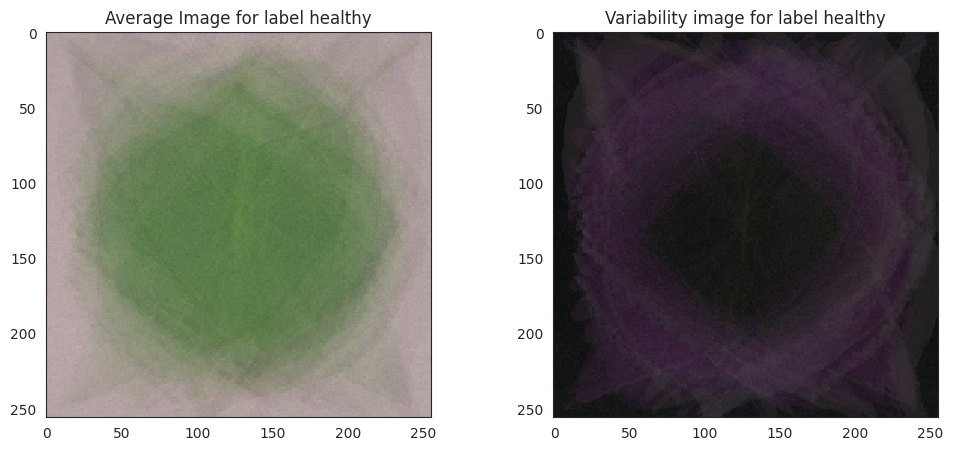

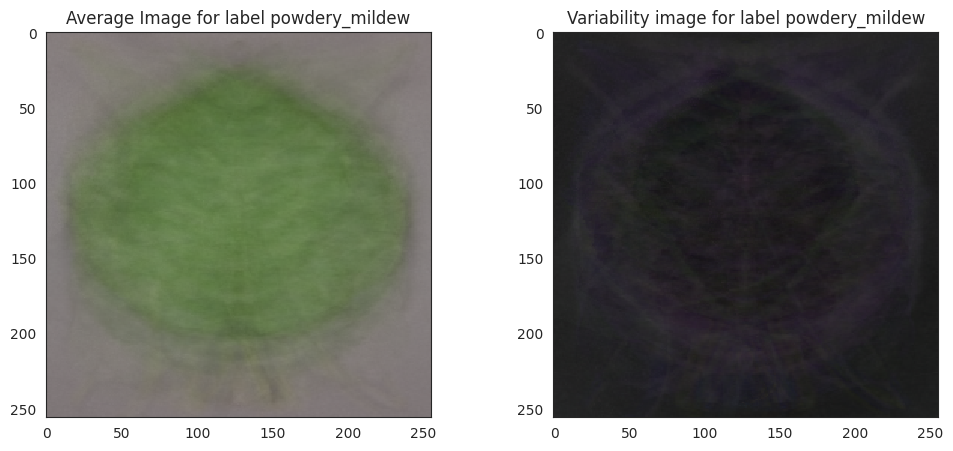

In [16]:
plot_mean_variability_per_label(X=X, y=y, figsize=(12, 5), save_image=True)

##  Difference between average healthy and average infected leaf images

In [17]:
# separate each label
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label_1 and label_2
    Plots a chart and saves it if save_image=True
    """

    sns.set_style('darkgrid')

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f'Error:\n{label_1} or {label_2} no in {np.unique(y)}')
        return

    # calculate mean from label_1
    images_label = subset_image_label(X, y, label_1)
    label_1_avg = np.mean(images_label, axis=0)

    # calculate mean from label_2
    images_label = subset_image_label(X, y, label_2)
    label_2_avg = np.mean(images_label, axis=0)

    # calculate and plot difference and average for both labels
    difference_mean = label_1_avg - label_2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label_1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label_2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:  # will overwrite if previous exists
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
        print(f'Figure saved: {file_path}/avg_diff.png')
    else:
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved: outputs/v6/avg_diff.png


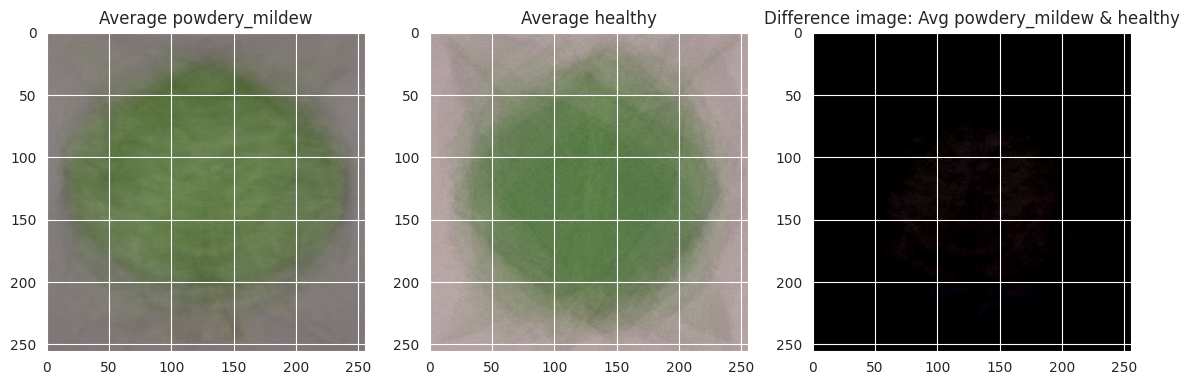

In [18]:
diff_bet_avg_image_labels_data_as_array(
    X=X,
    y=y,
    label_1='powdery_mildew',
    label_2='healthy',
    figsize=(14, 10),
    save_image=True
    )

# Create Image Montage

In [19]:
import random
import itertools
sns.set_style('darkgrid')

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10), n_images=20):  # TODO n_images after testing
    """
    If the label exists in the directory
    check if your montage space is greater than the subset size.
    Create a list of axes indices based on nrows and ncols.
    Create a Figure and display images.
    Load and plot images.
    """

    labels = os.listdir(dir_path)

    # subset the desired class
    if label_to_display in labels:

        # confirm montage space is larger than subset
        images_list = os.listdir(dir_path + '/' + label_to_display)

        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print('Reduce nrows or ncols to create montage\n')
            print(f'There are {len(images_list)} in your subset\n')
            print(f'You requested {ncols * ncols} spaces')
            return

        # create list of axes indices of all nrows and ncols combinations
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f'Width: {img_shape[1]}px x Height: {img_shape[0]}px\n')
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print(f"The label you selected ({label_to_display}) doesn't exist")
        print(f'The existing options: {labels}')


healthy


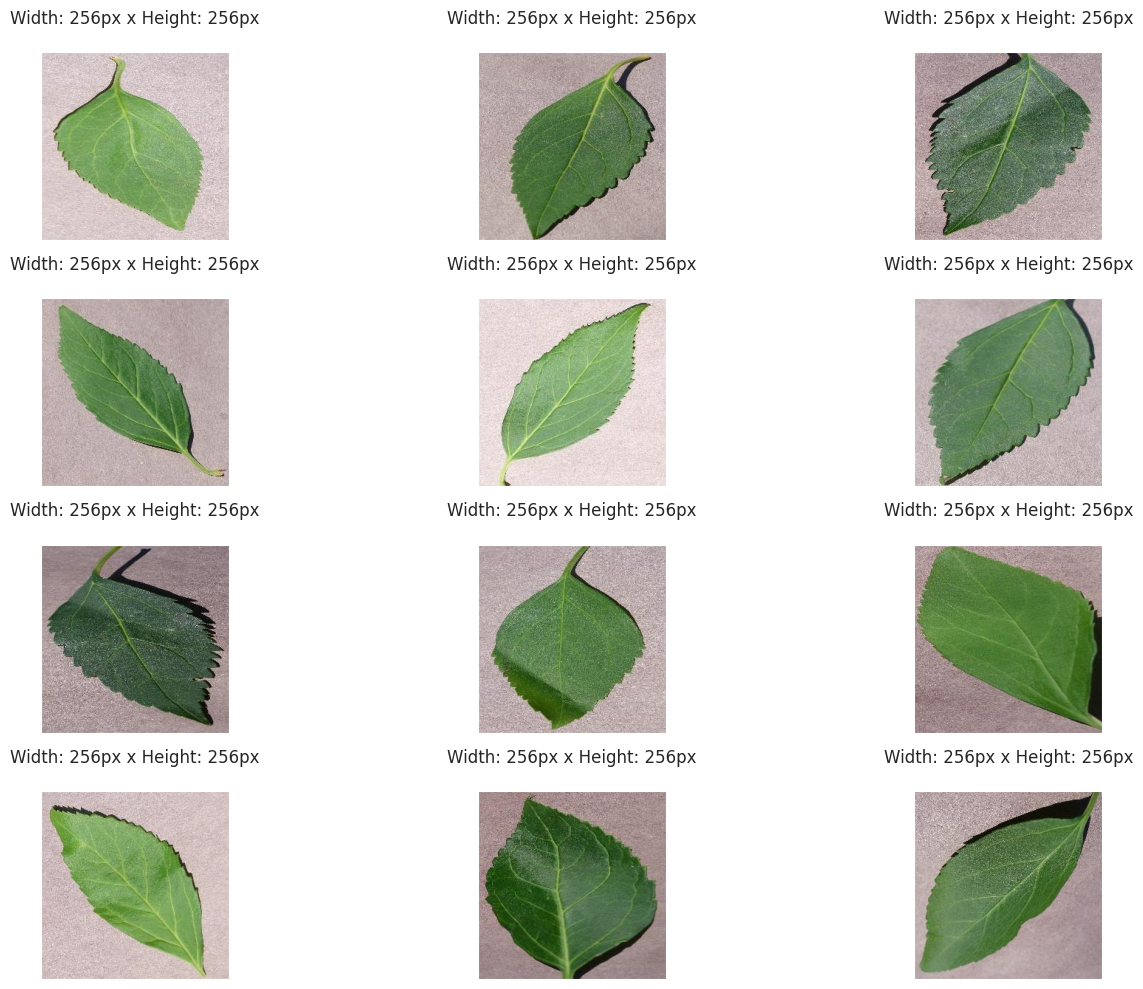

powdery_mildew


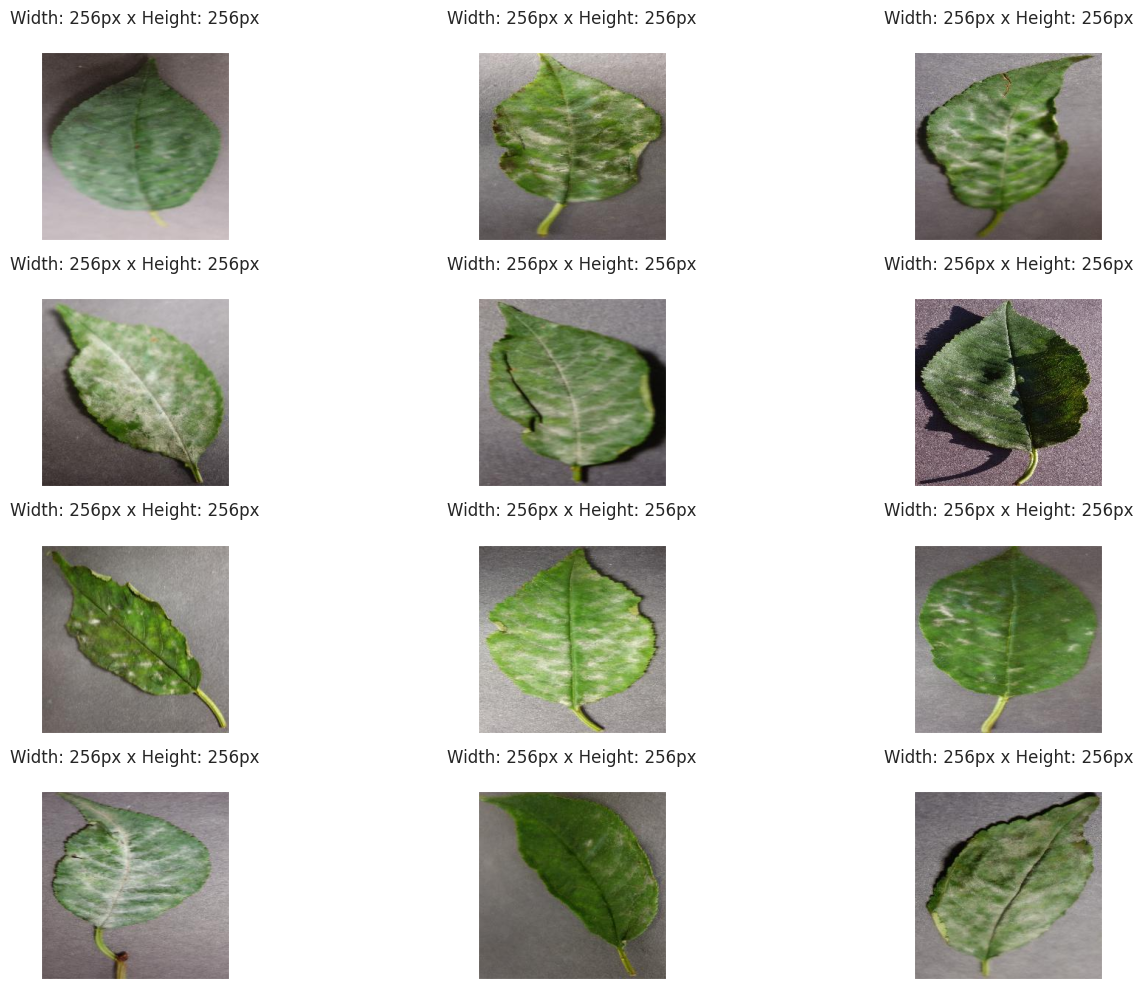

In [20]:
# show image montage 
for label in labels:
    print(label)
    image_montage(
        dir_path=train_path,
        label_to_display = label,
        nrows=4,
        ncols=3,
        )

## Conclusions:

Image montage for both healthy and infected leaves has been created and the
following observations have been made:
- The montage shows healthy leaf images are mostly green
- The montage shows infected leaf images do display clear signs of white powdery
mildew patterns
- Whilst to the human eye, the mean average image per label appears similar,
the distinction between individual images of each class are clearly visible from the
montage: given the distinct color differences between healthy and infected leaves,
this should not be difficult for a CNN to learn and is an appropriate problem for
which a CNN will be able to provide a robust solution according to the required
accuracy metrics defined by the client's business requirements.
- The image dataset is overall very small for a CNN. Whilst developing the model,
overfitting will be likely and Image augmentation will be neccessary for effective
learning.


---

### Ensure plots / montages are staged for commit:

In [21]:
!git add outputs/data_visaulisation

fatal: pathspec 'outputs/data_visaulisation' did not match any files
